In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from category_encoders.target_encoder import TargetEncoder
from sklearn.feature_selection import SelectKBest, chi2

# ignorando warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando os dados

df_train = pd.read_csv('../datasets/application_train.csv')
df_train.drop(['SK_ID_CURR'], axis=1, inplace=True)

In [3]:
df_train.shape

(307511, 121)

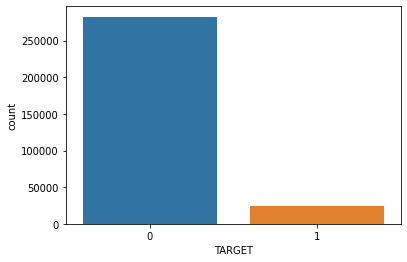

In [4]:
# Verificando a distribuição do target

sns.countplot(df_train['TARGET']);

In [5]:
# Checando se existem colunas com valores duplicados

comb = list(itertools.combinations(df_train.columns, 2))

dup_cols = []
for col1, col2 in comb:
    if((col1 not in dup_cols) & (col2 not in dup_cols)):
        if df_train[col1].equals(df_train[col2]):
            dup_cols.append(col1)
            
print('Quantidade de colunas com valores duplicados: ',len(dup_cols))

Quantidade de colunas com valores duplicados:  0


In [6]:
# Separando em features categóricas e numéricas

categ_features = df_train.select_dtypes(exclude=np.number)
numeric_features = df_train.select_dtypes(include=np.number)

### Iniciando o tratamento das features numéricas

In [7]:
# Dropando features com uma quantidade de valores nulos superior a 50%

numeric_features = numeric_features.loc[:, numeric_features.isnull().mean() < 0.5]

In [8]:
# Utilizando VarianceThreshold para descartar features com baixa variâcia

# Escalando os dados
scaler = StandardScaler()
normalized_df = scaler.fit_transform(numeric_features)
normalized_df = pd.DataFrame(normalized_df, columns=numeric_features.columns)

# Selecionado as features com baixa variância
vt = VarianceThreshold(threshold=1)
_ = vt.fit(normalized_df)
mask = vt.get_support()

# Dropando as features selecionadas
numeric_features = numeric_features.drop(numeric_features.loc[:, mask], axis=1)

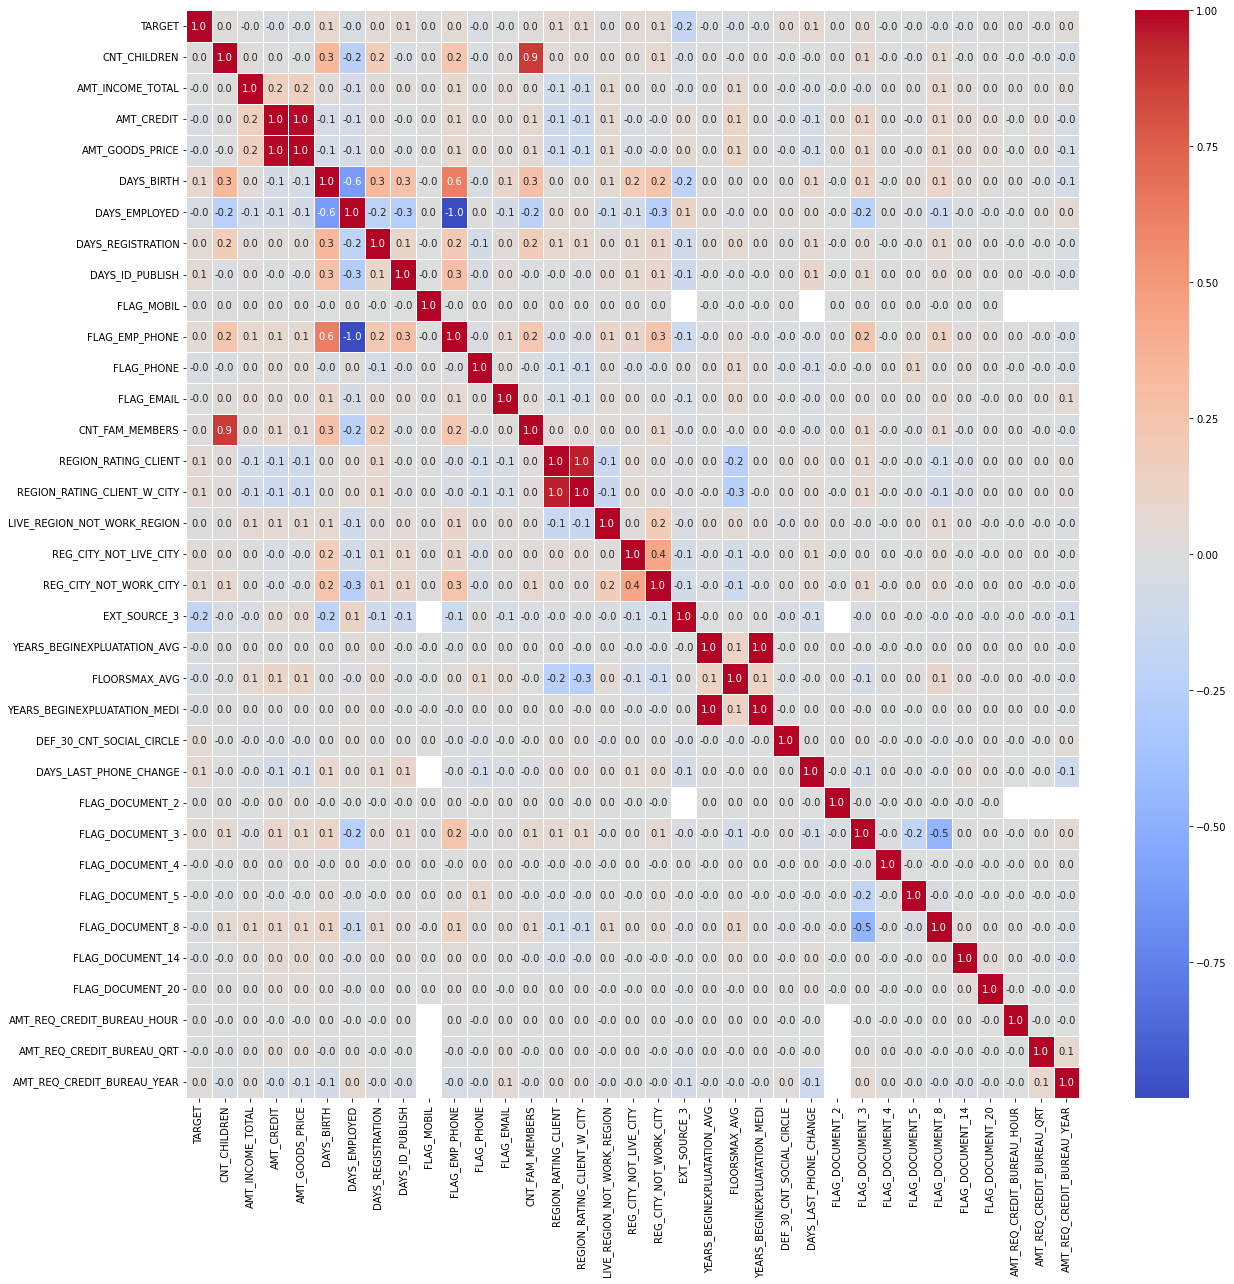

In [12]:
# Utilizando o heatmap para avaliar as correlações

correlation = numeric_features.corr()
plt.figure(figsize=[20,20])
sns.heatmap(data=correlation,
            annot=True,
            linewidths=1,
            fmt='.1f',
            cmap='coolwarm'
           ).get_figure().savefig('../images/heatmap.png')

In [13]:
# Dropando features com alta correlação (0.9 - 1.0)

numeric_features.drop(['CNT_CHILDREN','AMT_GOODS_PRICE','FLAG_EMP_PHONE','REGION_RATING_CLIENT_W_CITY',
                       'YEARS_BEGINEXPLUATATION_AVG'],
               axis=1, inplace=True)

In [14]:
# Verificando se as features restantes possuem valores nulos

numeric_features.isna().sum()

TARGET                               0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
FLAG_MOBIL                           0
FLAG_PHONE                           0
FLAG_EMAIL                           0
CNT_FAM_MEMBERS                      2
REGION_RATING_CLIENT                 0
LIVE_REGION_NOT_WORK_REGION          0
REG_CITY_NOT_LIVE_CITY               0
REG_CITY_NOT_WORK_CITY               0
EXT_SOURCE_3                     60965
FLOORSMAX_AVG                   153020
YEARS_BEGINEXPLUATATION_MEDI    150007
DEF_30_CNT_SOCIAL_CIRCLE          1021
DAYS_LAST_PHONE_CHANGE               1
FLAG_DOCUMENT_2                      0
FLAG_DOCUMENT_3                      0
FLAG_DOCUMENT_4                      0
FLAG_DOCUMENT_5                      0
FLAG_DOCUMENT_8                      0
FLAG_DOCUMENT_14         

In [15]:
# Inserindo a mediana no lugar dos valores nulos com SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)
imputer = imputer.fit(numeric_features)
numeric_df = imputer.transform(numeric_features)

numeric_features = pd.DataFrame(numeric_df, columns=numeric_features.columns)

#### Observamos que executando o código abaixo para remoção de outliers, todos os registros da classe 1 eram excluídos
```python
Q1 = numeric_features.quantile(0.25)
Q3 = numeric_features.quantile(0.75)
IQR = Q3 - Q1

result = numeric_features[~((numeric_features < (Q1 - 1.5 * IQR)) |(numeric_features > (Q3 + 1.5 * IQR))).any(axis=1)]
```

#### Resolvemos separar por TARGET para avaliar os outliers individualmente

In [16]:
# Separando o dataset por TARGET

df_t1 = numeric_features[numeric_features.TARGET == 1]
df_t0 = numeric_features[numeric_features.TARGET == 0]

In [17]:
# Removendo os outliers da classe 1

Q1 = df_t1.quantile(0.25)
Q3 = df_t1.quantile(0.75)
IQR = Q3 - Q1

result_1 = df_t1[~((df_t1 < (Q1 - 1.5 * IQR)) |(df_t1 > (Q3 + 1.5 * IQR))).any(axis=1)]

In [18]:
# Removendo os outliers da classe 0

Q1 = df_t0.quantile(0.25)
Q3 = df_t0.quantile(0.75)
IQR = Q3 - Q1

result_0 = df_t0[~((df_t0 < (Q1 - 1.5 * IQR)) |(df_t0 > (Q3 + 1.5 * IQR))).any(axis=1)]

In [19]:
# Concatenando os datasets novamente após a remoção dos outliers

df_num = pd.concat([result_1,result_0], axis=0)

In [20]:
# Verificando o resultado do tratamento das features numéricas

print(f'Quantidade de features numéricas originais: {df_train.select_dtypes(include=np.number).shape[1]}')
print(f'Quantidade de features numéricas após o tratamento: {df_num.shape[1]}')

Quantidade de features numéricas originais: 105
Quantidade de features numéricas após o tratamento: 30


In [16]:
# Salvando o dataset tratado somente com as features numéricas em arquivo

df_num.to_csv('df_num_features.csv')

### Iniciando o tratamento das features categóricas

In [21]:
# Separando x_categorico e y_categorico

x_cat = categ_features
y_cat = df_train['TARGET']

# Inserindo a string 'Unknown' no lugar dos valores nulos

x_cat = x_cat.fillna('Unknown')

# Codificando variáveis categóricas

te = TargetEncoder()
cod = te.fit(x_cat, y_cat)

In [22]:
# Selecionando as melhores features

x_cod = pd.DataFrame(cod.transform(x_cat), columns=x_cat.columns)

selector = SelectKBest(chi2, k=8).fit(x_cod, y_cat)
df_categ = x_cod.loc[:, selector.get_support()]

In [23]:
# Concatenando os datasets numérico e categórico

df_final = pd.concat([df_num,df_categ], axis=1, join='inner').reset_index(drop=True)

In [24]:
# Verificando o resultado do tratamento das features categóricas

print(f'Quantidade de features categóricas originais: {df_train.select_dtypes(exclude=np.number).shape[1]}')
print(f'Quantidade de features categóricas após o tratamento: {df_categ.shape[1]}')

Quantidade de features categóricas originais: 16
Quantidade de features categóricas após o tratamento: 8


In [21]:
# Salvando o dataset final em arquivo

df_final.to_csv('df_final.csv')